In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier

In [2]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from util import read_data, get_statistics_h5, calculate_weights
from dataset import train_validation_test_split_wth_augmentation, DatasetGeneratorPreprocessedH5
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from models import PretrainedModel, resnet18
from sklearn.metrics import f1_score

In [3]:
from skorch.callbacks import LRScheduler
import torch.optim as optim
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

#### Set all random seeds to the specific value, so the results are more reproducable

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

#### Define all necessary parameters

In [75]:
dataset_name = "wbc"
CLASS_NAMES =  [' unknown', ' CD4+ T', ' CD8+ T', ' CD15+ neutrophil', ' CD14+ monocyte', ' CD19+ B', ' CD56+ NK', ' NKT', ' eosinophil']
only_channels = [0,1,2,3,4,5,6,7,8,9,10,11]
path_to_data ="..\..\data/WBC/experiment/donor/condition"
model_dir = "models_remote"
scaling_factor = 4095.
reshape_size = 64
num_channels = len(only_channels)
train_transform = transforms.Compose(
        [
            #transforms.ToPILImage(),
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(1),
         #transforms.ToTensor()
        ])
test_transform = transforms.Compose([])
channels = np.array(["BF1", "CD15", "SigL8", "CD14", "CD19", "DF", "CD3", "CD45", "BF2", "CD4", "CD56", "CD8"])

In [76]:
batch_size = 64
num_workers = 2
device="cuda"

#### Load data

In [77]:
X, y, class_names, data_map = read_data(path_to_data)

In [78]:
num_classes = len(data_map.keys())

In [79]:
assert len(CLASS_NAMES) == num_classes 

#### Split data

In [80]:
train_indx, validation_indx, test_indx = train_validation_test_split_wth_augmentation(X, y, only_classes=None, seed=seed_value)

In [83]:
train_dataset = DatasetGeneratorPreprocessedH5(path_to_data=path_to_data,
                                                      set_indx=train_indx,
                                                      scaling_factor=scaling_factor,
                                                      reshape_size=reshape_size,
                                                      transform=train_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels)

In [85]:
import h5py

In [86]:
r = h5py.File(os.path.join(path_to_data, '{}.h5'.format(12901)), 'r')
image_original = r.get('image')[()] / scaling_factor

In [87]:
label = r.get('label')[()]
mask_formatted = False
if 'mask' not in r.keys() or isinstance(r.get('mask')[()], h5py._hl.base.Empty):
    mask_original = torch.from_numpy(
    np.zeros((num_channels, reshape_size, reshape_size), dtype=np.float64))
    mask_formatted = True
else:
    mask_original = r.get('mask')[()]

In [88]:
label

b'CD4+ T'

In [89]:
from dataset import crop_pad_h_w
h, w = crop_pad_h_w(image_original, reshape_size)
h1_crop, h2_crop, h1_pad, h2_pad = h
w1_crop, w2_crop, w1_pad, w2_pad = w
image = np.zeros((num_channels, reshape_size, reshape_size), dtype=np.float32)
mask = np.zeros((num_channels, reshape_size, reshape_size), dtype=np.float32)

In [90]:
from skimage.util import crop
nmb_of_channels = 0
            # filling the image with different channels
for ch in range(image_original.shape[2]):
    if len(only_channels) == 0 or ch in only_channels:
        image_dummy = crop(image_original[:, :, ch], ((h1_crop, h2_crop), (w1_crop, w2_crop)))
        image_dummy = np.pad(image_dummy, ((h1_pad, h2_pad), (w1_pad, w2_pad)), "edge")
        image[nmb_of_channels, :, :] = image_dummy

        # do the same for the mask
        if not mask_formatted:
            mask_dummy = crop(mask_original[:, :, ch], ((h1_crop, h2_crop), (w1_crop, w2_crop)))
            mask_dummy = np.pad(mask_dummy, ((h1_pad, h2_pad), (w1_pad, w2_pad)), "edge")
            mask[nmb_of_channels, :, :] = mask_dummy
            nmb_of_channels += 1
        else:
            mask[nmb_of_channels, :, :] = mask_original[nmb_of_channels, :, :]

In [91]:
import copy
image = torch.from_numpy(copy.deepcopy(image))

In [92]:
image[0]

tensor([[0.1976, 0.1976, 0.1976,  ..., 0.1973, 0.1973, 0.1973],
        [0.1976, 0.1976, 0.1976,  ..., 0.1978, 0.1978, 0.1978],
        [0.1968, 0.1968, 0.1968,  ..., 0.1971, 0.1971, 0.1971],
        ...,
        [0.1983, 0.1983, 0.1983,  ..., 0.1951, 0.1951, 0.1951],
        [0.1983, 0.1983, 0.1983,  ..., 0.1949, 0.1949, 0.1949],
        [0.1963, 0.1963, 0.1963,  ..., 0.1968, 0.1968, 0.1968]])

In [93]:
only_classes = None

In [94]:
label

b'CD4+ T'

In [95]:
if train_dataset.transform:
    image = train_dataset.transform(image)

In [96]:
image[0]

tensor([[0.1973, 0.1973, 0.1973,  ..., 0.1976, 0.1976, 0.1976],
        [0.1978, 0.1978, 0.1978,  ..., 0.1976, 0.1976, 0.1976],
        [0.1971, 0.1971, 0.1971,  ..., 0.1968, 0.1968, 0.1968],
        ...,
        [0.1951, 0.1951, 0.1951,  ..., 0.1983, 0.1983, 0.1983],
        [0.1949, 0.1949, 0.1949,  ..., 0.1983, 0.1983, 0.1983],
        [0.1968, 0.1968, 0.1968,  ..., 0.1963, 0.1963, 0.1963]])

In [97]:
train_loader = DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers)

#### Oversamle and use class weights for imbalance data

In [98]:
y_train = [data_map.get(y[i]) for i in train_indx]
weights = calculate_weights(y_train)
oversample = RandomOverSampler(random_state=seed_value, sampling_strategy='all')

In [99]:
train_indx, y_train = oversample.fit_resample(np.asarray(train_indx).reshape(-1, 1), np.asarray(y_train))
train_indx = train_indx.T[0]
y_train = [data_map.get(y[i]) for i in train_indx]

#### Calculate statistics of train set and normalize the data

In [100]:
statistics = get_statistics_h5(train_loader, only_channels, None, num_channels)

In [101]:
train_dataset = DatasetGeneratorPreprocessedH5(path_to_data=path_to_data,
                                                      set_indx=train_indx,
                                                      scaling_factor=scaling_factor,
                                                      reshape_size=reshape_size,
                                                      transform=train_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels,
                                                      means=statistics["mean"],
                                                      stds=statistics["std"],
                                                  return_only_image=True,
                                                      )

validation_dataset = DatasetGeneratorPreprocessedH5(path_to_data=path_to_data,
                                                           set_indx=validation_indx,
                                                           scaling_factor=scaling_factor,
                                                           reshape_size=reshape_size,
                                                           transform=test_transform,
                                                           data_map=data_map,
                                                           only_channels=only_channels,
                                                           num_channels=num_channels,
                                                           means=statistics["mean"],
                                                           stds=statistics["std"],
                                                       return_only_image=True,
                                                           )

test_dataset = DatasetGeneratorPreprocessedH5(path_to_data=path_to_data,
                                                     set_indx=test_indx,
                                                     scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                     transform=test_transform,
                                                     data_map=data_map,
                                                     only_channels=only_channels,
                                                     num_channels=num_channels,
                                                     means=statistics["mean"],
                                                     stds=statistics["std"],
                                                 return_only_image=True,
                                                     )

In [102]:
train_dataset[0]

(tensor([[[ 0.1434,  0.1434,  0.1434,  ...,  0.1221,  0.1221,  0.1221],
          [ 0.1434,  0.1434,  0.1434,  ...,  0.1647,  0.1647,  0.1647],
          [ 0.0795,  0.0795,  0.0795,  ...,  0.1008,  0.1008,  0.1008],
          ...,
          [ 0.2073,  0.2073,  0.2073,  ..., -0.0695, -0.0695, -0.0695],
          [ 0.2073,  0.2073,  0.2073,  ..., -0.0908, -0.0908, -0.0908],
          [ 0.0370,  0.0370,  0.0370,  ...,  0.0795,  0.0795,  0.0795]],
 
         [[-0.3791, -0.3791, -0.3791,  ..., -0.3973, -0.3973, -0.3973],
          [-0.3791, -0.3791, -0.3791,  ..., -0.3973, -0.3973, -0.3973],
          [-0.3882, -0.3882, -0.3882,  ..., -0.3973, -0.3973, -0.3973],
          ...,
          [-0.3700, -0.3700, -0.3700,  ..., -0.3882, -0.3882, -0.3882],
          [-0.3609, -0.3609, -0.3609,  ..., -0.3882, -0.3882, -0.3882],
          [-0.3700, -0.3700, -0.3700,  ..., -0.3791, -0.3791, -0.3791]],
 
         [[ 0.4129,  0.4129,  0.4129,  ..., -1.1841, -1.1841, -1.1841],
          [-0.3856, -0.3856,

#### Set all hyperparameters for the model

In [17]:
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.5)

In [18]:
checkpoint = Checkpoint(
    f_params='wbc_net_all_.pth', monitor='valid_loss_best', dirname='models')
train_end_cp = TrainEndCheckpoint(f_params='final_wbc_net_all_.pth', dirname='models')

In [19]:
class_weights = torch.FloatTensor(weights).to(device)

### Initialite and train the model

In [24]:
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    #criterion__weight=class_weights,
    lr=0.001,
    batch_size=64,
    max_epochs=10,
    module__output_features=num_classes,
    module__num_channels=num_channels, 
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=False,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lrscheduler, checkpoint, train_end_cp],
    train_split=predefined_split(validation_dataset),
    device='cuda' # comment to train on cpu
)

In [22]:
torch.cuda.empty_cache()

In [25]:
net.fit(train_dataset, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp       dur
-------  ------------  -----------  ------------  ----  --------
      1           nan       0.0410       69.8685     +  214.7066
      2       -0.0024       0.0410       69.8650     +  226.3823
      3       -0.0024       0.0410       69.8618     +  224.4246


Exception ignored in: <function _DataLoaderIter.__del__ at 0x000001D27A964B88>
Traceback (most recent call last):
  File "C:\Users\Alexa\anaconda3\envs\iflai\lib\site-packages\torch\utils\data\dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "C:\Users\Alexa\anaconda3\envs\iflai\lib\site-packages\torch\utils\data\dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "C:\Users\Alexa\anaconda3\envs\iflai\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "C:\Users\Alexa\anaconda3\envs\iflai\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_si

### Model Evaluation

In [72]:
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

In [21]:
#net.save_params(f_params='final_wbc_net_all_.pth')
model = PretrainedModel(num_classes, num_channels)
checkpoint = torch.load('models/wbc_net_all_.pth')
model.load_state_dict(checkpoint)
model = model.to(dev)

In [22]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(dev).float(), data[1].to(dev).long()
        #Tracer()()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())

In [23]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                  precision    recall  f1-score   support

  CD14+ monocyte     0.9623    0.9961    0.9789       256
CD15+ neutrophil     0.9984    1.0000    0.9992      3665
         CD19+ B     0.9944    1.0000    0.9972       178
          CD4+ T     0.9866    0.9844    0.9855       895
        CD56+ NK     0.9627    0.9627    0.9627       134
          CD8+ T     0.9355    0.9721    0.9534       358
             NKT     0.7657    0.8883    0.8225       206
      eosinophil     0.9968    1.0000    0.9984       307
         unknown     0.9590    0.7276    0.8274       257

        accuracy                         0.9803      6256
       macro avg     0.9512    0.9479    0.9472      6256
    weighted avg     0.9814    0.9803    0.9800      6256



In [24]:
y_pred_net = net.predict(test_dataset)
#print(classification_report(y_true, y_pred_net, target_names=class_names, digits=4))

In [25]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar
import os

def classification_complete_report(estimator, X, y_true, plot = True, class_names=[], path_to_save_fig = "images", file_name="test.svg" ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred,target_names=class_names))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        disp = plot_confusion_matrix(estimator, X, y_true,display_labels=class_names, cmap=plt.cm.Greys, xticks_rotation='vertical')
        plt.setp(disp.ax_.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
        disp.figure_.savefig(os.path.join(path_to_save_fig, file_name), bbox_inches='tight')

                  precision    recall  f1-score   support

  CD14+ monocyte       0.97      0.99      0.98       256
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       1.00      1.00      1.00       178
          CD4+ T       0.98      0.99      0.99       895
        CD56+ NK       0.98      0.97      0.98       134
          CD8+ T       0.96      0.97      0.97       358
             NKT       0.81      0.88      0.85       206
      eosinophil       1.00      1.00      1.00       307
         unknown       0.94      0.81      0.87       257

        accuracy                           0.98      6256
       macro avg       0.96      0.96      0.96      6256
    weighted avg       0.98      0.98      0.98      6256

------------------------------------------------------------
matthews correlation coeff: 0.9744
Cohen Kappa score: 0.9744
Accuracy: 0.9840 & balanced Accuracy: 0.9567
macro F1 score: 0.9583 & micro F1 score: 0.9840
macro Precision score: 0.961

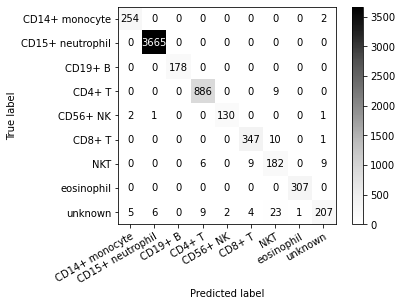

In [26]:
classification_complete_report(net, 
                               test_dataset, 
                               y_true, class_names=class_names, file_name="CM_WBC_all_resnet.png")

### Model Interpretation

In [27]:
from time import process_time

In [28]:
model_name = "resnet_all"

#### Pixel-Permutation Tests

Candidate channel is 4
Elapsed time: 1352.03125 1224.9375
Elapsed time during the whole program in seconds: 127.09375


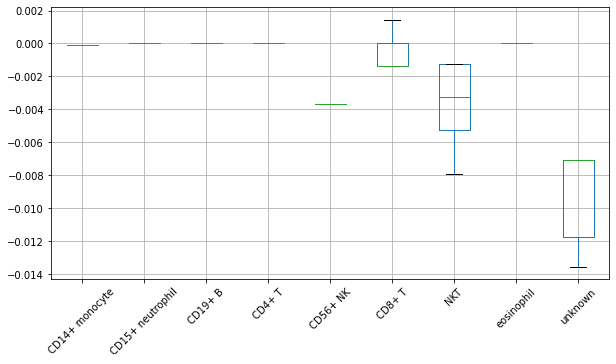

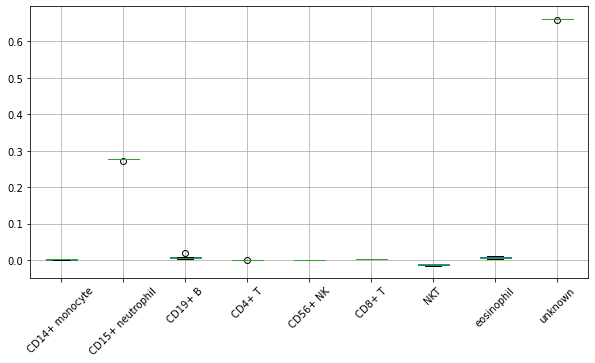

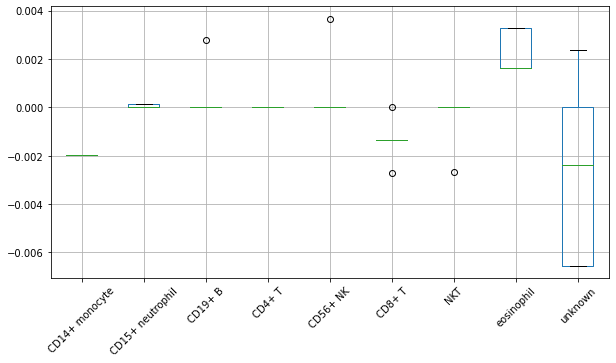

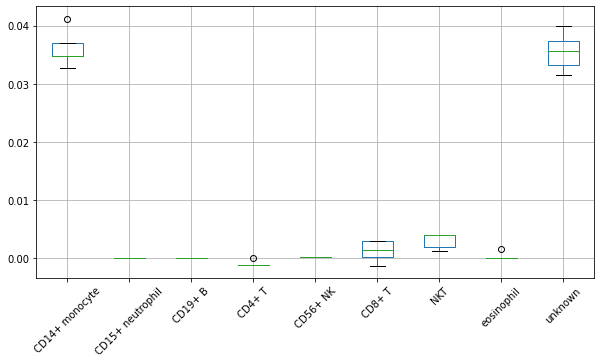

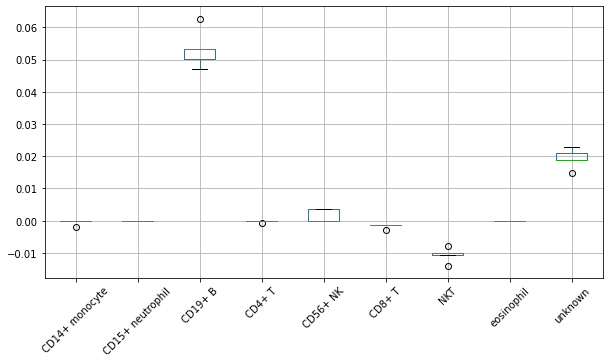

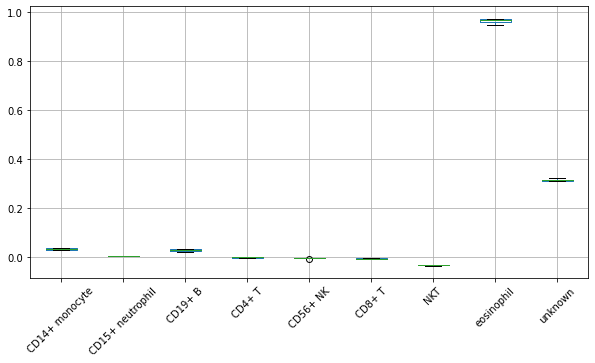

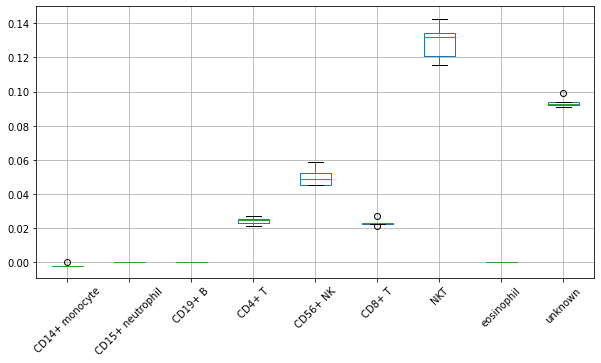

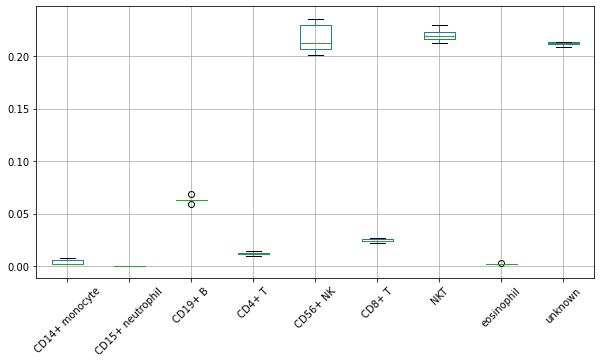

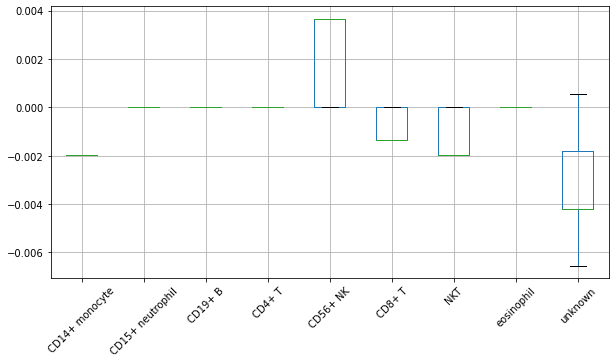

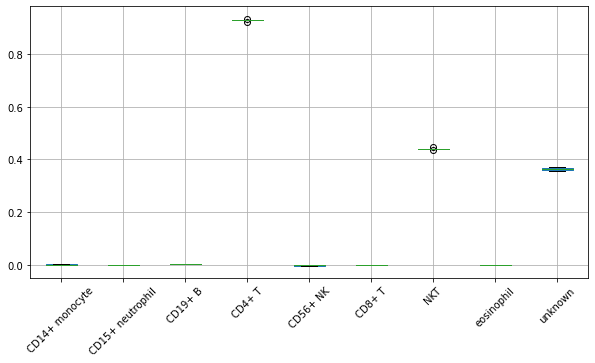

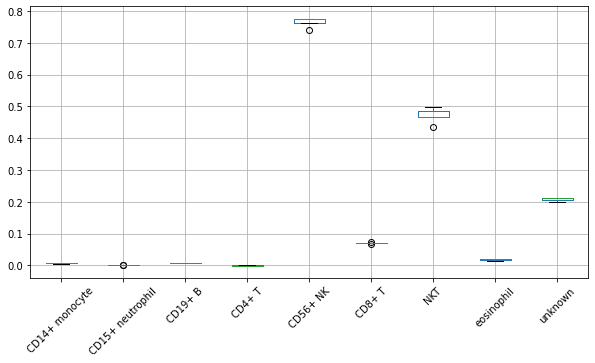

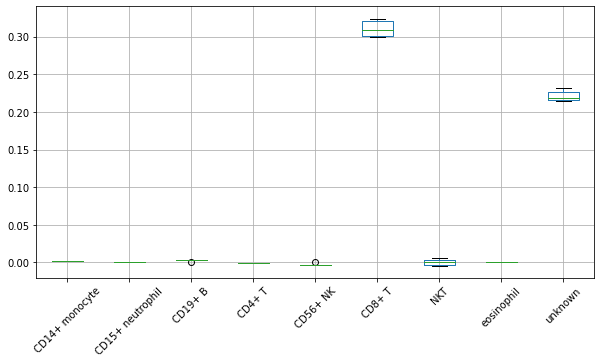

In [29]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred_net, average=None, labels=np.arange(num_classes))
shuffle_times = 5
min_mean_dif = 1.0
candidate = 0
df_all = pd.DataFrame([], columns=class_names)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    for s in range(shuffle_times):
        dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                      set_indx=test_indx,
                                                      scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                      transform=test_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels,
                                                      means=statistics["mean"],
                                                      stds=statistics["std"],
                                                    channels_to_shuffle=[c],
                                                    return_only_image=True)
        y_pred_shuffle_net = net.predict(dataset)
        f1_score_per_channel = f1_score(y_true, y_pred_shuffle_net, average=None, labels=np.arange(num_classes))
        f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
        
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0:
        min_mean_dif = mean_dif
        candidate = only_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names, rotation=45)
    fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(only_channels[c]))))
print("Candidate channel is {}".format(candidate))
t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start)

t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred_net, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
df_all = pd.DataFrame([], columns=CLASS_NAMES)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    for s in range(shuffle_times):
        dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                      set_indx=test_indx,
                                                      scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                      transform=test_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels,
                                                      means=statistics["mean"],
                                                      stds=statistics["std"],
                                                    channels_to_shuffle=[c]
                                                      )
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data["image"].to(device).float(), data["label"].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not only_channels[c] in [0,5,8]:
        min_mean_dif = mean_dif
        candidate = only_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=CLASS_NAMES)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=CLASS_NAMES)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(CLASS_NAMES, rotation=45)
    fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(only_channels[c]))))
print("Candidate channel is {}".format(candidate))

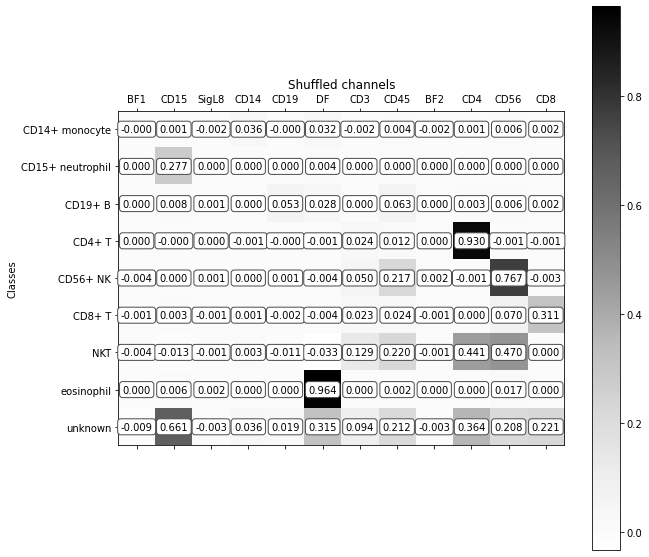

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(df_all.T, cmap=plt.cm.Greys)
cbar = fig.colorbar(cax)
ax.set_yticks(list(range(len(class_names))))
ax.set_yticklabels(class_names, rotation=0)
ax.set_xticks(list(range(len(only_channels))))
ax.set_xticklabels(channels[np.asarray(only_channels)])
ax.set_title('Shuffled channels')
ax.set_ylabel('Classes')
for (i, j), z in np.ndenumerate(df_all.T):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
   # ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.show()
fig.savefig(os.path.join("results",model_name, "{}-heatmap-{}.png".format(dataset_name, str(model_name))), bbox_inches='tight')

In [31]:
import seaborn

In [32]:
data=pd.DataFrame(columns=channels, data=heatmaps_deeplift.cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11
CD14+ monocyte,-0.000067,0.001111,-0.001964,0.036078,-0.000446,0.032484,-0.001571,0.003670,-0.001964,0.000732,5.974586e-03,0.001897
CD15+ neutrophil,0.000000,0.276643,0.000054,0.000000,0.000000,0.004190,0.000000,0.000299,0.000000,0.000000,5.202118e-08,0.000000
CD19+ B,0.000000,0.008323,0.000560,0.000000,0.053280,0.028359,0.000000,0.063331,0.000000,0.002801,5.586592e-03,0.002241
CD4+ T,0.000000,-0.000113,0.000000,-0.000905,-0.000113,-0.001360,0.024455,0.011850,0.000000,0.929760,-1.069011e-03,-0.001127
CD56+ NK,-0.003688,0.000000,0.000732,0.000171,0.001464,-0.004346,0.050171,0.217179,0.002197,-0.001475,7.666032e-01,-0.002951
CD8+ T,-0.000521,0.003118,-0.001349,0.001192,-0.001636,-0.004398,0.023399,0.024277,-0.000809,0.000295,6.956836e-02,0.310903
NKT,-0.003796,-0.013199,-0.000535,0.002993,-0.010501,-0.032666,0.129024,0.220233,-0.001184,0.441279,4.704043e-01,0.000421
eosinophil,0.000000,0.006443,0.002286,0.000326,0.000000,0.963848,0.000000,0.001959,0.000000,0.000000,1.723121e-02,0.000000
unknown,-0.009308,0.661305,-0.002619,0.035523,0.019265,0.314970,0.093632,0.211708,-0.003241,0.363655,2.080979e-01,0.221250


In [ ]:
swarm_plot_pixel_permutation = seaborn.swarmplot(data=pd.melt(data, var_name="channel"), size=1, x = "channel", y="value")

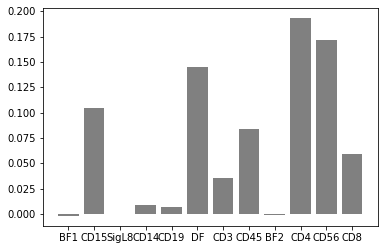

In [33]:
plt.bar(channels[np.asarray(only_channels)], df_all.T.mean(), color='Grey')
plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.png".format(dataset_name, str("resnet_all"))))

In [34]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': df_all.T.mean().to_numpy()})

In [35]:
channel_ranking_pixel_permutation

,channels,importance
0,BF1,-0.001931
1,CD15,0.104848
2,SigL8,-0.000315
3,CD14,0.008375
4,CD19,0.006813
5,DF,0.144565
6,CD3,0.035457
7,CD45,0.083834
8,BF2,-0.000556
9,CD4,0.193005


In [36]:
y_proba = net.predict_proba(test_dataset)

In [37]:
y_true_proba = np.array([j[i] for (i,j) in zip(y_true, y_proba)])

In [38]:
def calculate_aopc(channel_ranking, method='', ascending=True, perturb=False, plot=True):
    #channel_ranking = pd.DataFrame(data={"channels":channels_ranking, "importance": importance})
    sorted_channels = channel_ranking.sort_values(by="importance", ascending=ascending)
    y_proba = net.predict_proba(test_dataset)
    y_true_proba = np.array([j[i] for (i,j) in zip(y_true, y_proba)])
    channels_to_permute=[]
    differences = []
    # calculate (f^0 - f^k)
    for i in range(len(sorted_channels)):
        channels_to_permute.append(np.where(channels==sorted_channels.iloc[i]["channels"])[0][0])
        dataset_ = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                          set_indx=test_indx,
                                                          scaling_factor=scaling_factor,
                                                         reshape_size=reshape_size,
                                                          transform=test_transform,
                                                          data_map=data_map,
                                                          only_channels=only_channels,
                                                          num_channels=num_channels,
                                                          means=statistics["mean"],
                                                          stds=statistics["std"],
                                                        channels_to_shuffle=channels_to_permute,
                                                        return_only_image=True,
                                                    perturb=perturb)
        y_permut_proba = net.predict_proba(dataset_)
        y_true_permut_proba = [j[i] for (i,j) in zip(y_true, y_permut_proba)]
        differences.append(y_true_proba-np.array(y_true_permut_proba))
    stacked_diff = np.stack(differences)
    # calculate summ(f^0-f^k)
    diff_accumulated = []
    for idx, diff in enumerate(stacked_diff):
        if idx==0:
            diff_accumulated.append(stacked_diff[idx])
        else:
            diff_accumulated.append(diff_accumulated[idx-1] + stacked_diff[idx])
    diff_accumulated = np.stack(diff_accumulated)
    # mean over the test set
    diff_accumulated_mean = np.mean(diff_accumulated, axis=-1)
    # divide by 1/L+1
    diff_accumulated_mean_norm = np.array([])
    for ix, d in enumerate(diff_accumulated_mean):
        diff_accumulated_mean_norm = np.append(diff_accumulated_mean_norm, d/(ix+1))
    # insert (0,0)
    diff_accumulated_mean_norm_started_from_0 = np.insert(diff_accumulated_mean_norm,0,0.0)
    # plot line
    if plot:
        x = np.arange(len(diff_accumulated_mean_norm_started_from_0))
        plt.xlabel("permutation steps")
        plt.ylabel("AOPC")
        plt.plot(x, diff_accumulated_mean_norm_started_from_0, color ="red")
        #plt.show()
        plt.savefig(os.path.join("results",model_name, "{}-aopc-{}-{}.svg".format(dataset_name, method, str("resnet_all"))))
    return diff_accumulated_mean_norm_started_from_0

In [39]:
#res_pixel_permutated = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-2')

In [40]:
#res_pixel_permutated_perturb = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-perturb', perturb=True)

In [41]:
#res_pixel_permutated_reverse = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-reverse-2', ascending=False)

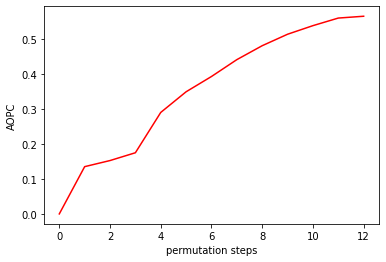

In [42]:
res_pixel_permutated_perturb_reverse = calculate_aopc(channel_ranking_pixel_permutation, method='pixel-permutation-perturb-reverse', ascending=False, perturb=True)

In [43]:
from captum.attr import Occlusion

In [44]:
device="cuda"

Elapsed time: 25635.546875 1384.03125
Elapsed time during the whole program in seconds: 24251.515625


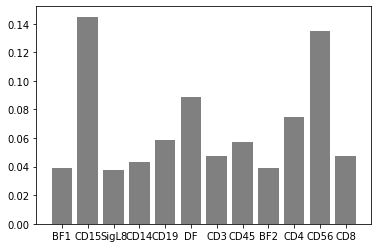

In [45]:
t1_start = process_time()
ablator = Occlusion(model)
dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                      set_indx=test_indx,
                                                      scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                      transform=test_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels,
                                                      means=statistics["mean"],
                                                      stds=statistics["std"]
                                                      )
dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps = torch.empty(0, dtype=torch.float32, device=dev)
with torch.no_grad():
    for data in dataloader:
        inputs, labels = data["image"].to(device).float(), data["label"].to(device).reshape(-1).long()
        attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
        heatmaps = torch.cat((heatmaps, torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=98, axis=-1)).to(dev)))
heatmaps_mean = torch.mean(heatmaps, dim=0)
plt.bar(channels[np.asarray(only_channels)], heatmaps_mean.cpu(), color='grey')
plt.savefig(os.path.join("results",model_name, "{}-occl_method-model-98-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

In [46]:
channel_ranking_occlusion = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': heatmaps_mean.cpu().numpy()})

In [178]:
heatmaps.shape

torch.Size([6256, 12])

In [54]:
channel_ranking_occlusion

,channels,importance
0,BF1,0.038704
1,CD15,0.144907
2,SigL8,0.037986
3,CD14,0.043138
4,CD19,0.058902
5,DF,0.088835
6,CD3,0.047226
7,CD45,0.056928
8,BF2,0.038776
9,CD4,0.074960


In [55]:
#res_pixel_occl = calculate_aopc(channel_ranking_occlusion, method='pixel-occlusion')

In [56]:
#res_pixel_occl_perturb = calculate_aopc(channel_ranking_occlusion, method='pixel-occlusion-perturb', perturb=True)

In [57]:
#res_pixel_occl_reverse = calculate_aopc(channel_ranking_occlusion, method='pixel-occlusion-reverse', ascending=False)

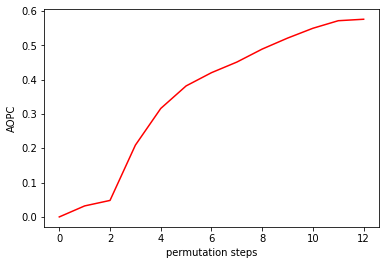

In [58]:
res_pixel_ocll_perturb_reverse = calculate_aopc(channel_ranking_occlusion, method='pixel-occlusion-perturb-reverse', ascending=False, perturb=True)

In [61]:
from captum.attr import Occlusion, DeepLift, IntegratedGradients, LRP
from time import process_time

In [62]:
device="cuda"

Elapsed time: 25710.640625 25693.78125
Elapsed time during the whole program in seconds: 16.859375


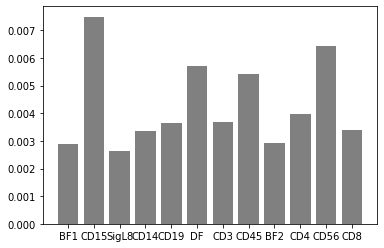

In [63]:
t1_start = process_time()
ablator = DeepLift(model)

test_dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                     set_indx=test_indx,
                                                     scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                     transform=test_transform,
                                                     data_map=data_map,
                                                     only_channels=only_channels,
                                                     num_channels=num_channels,
                                                     means=statistics["mean"],
                                                     stds=statistics["std"]
                                                     )
testloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)

heatmaps_deeplift = torch.empty(0, dtype=torch.float32, device=dev)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data["image"].to(device).float(), data["label"].to(device).reshape(-1).long()
        # baselines=torch.zeros(inputs.shape).to(dev)
        attr = ablator.attribute(inputs, target=labels)
        heatmaps_deeplift = torch.cat((heatmaps_deeplift,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=98, axis=-1)).to(dev)))
heatmaps_deeplift_mean = torch.mean(heatmaps_deeplift, dim=0)
plt.bar(channels, heatmaps_deeplift_mean.cpu(), color='grey')
plt.savefig(os.path.join("results", "resnet_all", "{}-deeplift_method-model-98-percentile-{}.png".format(dataset_name, str("resnet_all"))))

t1_stop = process_time()
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

In [64]:
heatmaps_deeplift.T.shape

torch.Size([12, 6256])

In [65]:
data=pd.DataFrame(columns=channels, data=heatmaps_deeplift.cpu().numpy())

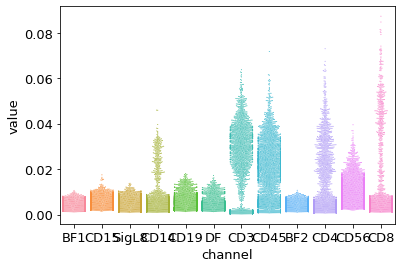

In [125]:
swarm_plot_deep_lift = seaborn.swarmplot(data=pd.melt(data, var_name="channel"), size=1, x = "channel", y="value")

In [126]:
fig = swarm_plot_deep_lift.get_figure()
fig.savefig(os.path.join("results", "resnet_all", "{}-deeplift-swarm.png".format(dataset_name))) 
fig.savefig(os.path.join("results", "resnet_all", "{}-deeplift-swarm.svg".format(dataset_name))) 

In [66]:
channel_ranking_deep_lift = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': heatmaps_deeplift_mean.cpu().numpy()})

In [67]:
channel_ranking_deep_lift

,channels,importance
0,BF1,0.002900
1,CD15,0.007495
2,SigL8,0.002633
3,CD14,0.003376
4,CD19,0.003663
5,DF,0.005705
6,CD3,0.003675
7,CD45,0.005416
8,BF2,0.002924
9,CD4,0.003968


In [68]:
#res_deep_lift_perturb = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-perturb', perturb=True)

In [69]:
#res_deep_lift = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-2')

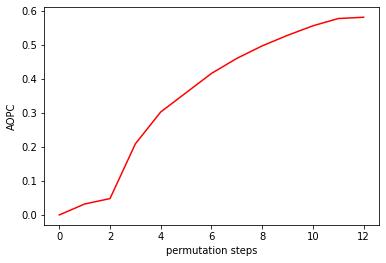

In [73]:
res_deep_lift_perturb_reverse = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-perturb-reverse', ascending=False, perturb=True)

In [ ]:
#res_deep_lift_reverse = calculate_aopc(channel_ranking_deep_lift, method='deep-lift-reverse-2', ascending=False)

#### Random

In [74]:
channel_ranking_random = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': np.random.randint(12, size=12)})

In [75]:
#res_random_perturb = calculate_aopc(channel_ranking_random, method='random-perturb', perturb=True)

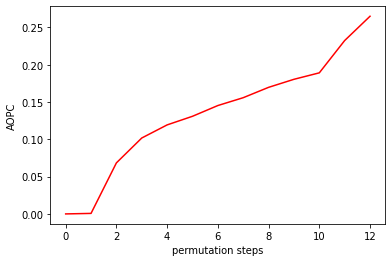

In [76]:
res_random_perturb_reverse = calculate_aopc(channel_ranking_random, method='random-perturb-reverse', ascending=False, perturb=True)

In [77]:
#res_random = calculate_aopc(channel_ranking_random, method='random-perturb-2')

In [78]:
#res_random_reverse = calculate_aopc(channel_ranking_random, method='random-reverse-2', ascending=False)

In [80]:
x = np.arange(len(res_random_perturb_reverse))

In [82]:
random_rankings = []

In [176]:
np.savetxt('random_ranking.txt', np.asarray(random_rankings), delimiter="\n")

In [163]:
mean = np.mean(np.asarray(random_rankings), axis=0)

In [164]:
mean

array([0.        , 0.02498536, 0.04270692, 0.0620615 , 0.08605267,
       0.11152298, 0.13857848, 0.16849697, 0.20056485, 0.23402396,
       0.26892054, 0.30439982, 0.33095601])

In [156]:
std = np.std(np.asarray(random_rankings), axis=0)

In [165]:
std

array([0.        , 0.03321363, 0.04889343, 0.06432018, 0.08024061,
       0.0953461 , 0.10809441, 0.11803006, 0.12553618, 0.12960211,
       0.12983576, 0.12467058, 0.11428137])

In [171]:
sample_std = np.std(np.asarray(random_rankings), axis=0, ddof=1) 

In [172]:
sample_std

array([0.        , 0.03323008, 0.04891765, 0.06435205, 0.08028037,
       0.09539333, 0.10814796, 0.11808853, 0.12559837, 0.12966631,
       0.12990008, 0.12473235, 0.11433798])

In [157]:
z=2.576

In [158]:
upper_border = mean + (z * (std / np.sqrt(len(random_rankings))))

In [159]:
lower_border = mean - (z * (std / np.sqrt(len(random_rankings))))

In [130]:
for i in range(100):
    channel_ranking_random = pd.DataFrame(data={'channels': channels[np.asarray(only_channels)], 'importance': np.random.randint(12, size=12)})
    random_rankings.append(calculate_aopc(channel_ranking_random, method='random-perturb-reverse', ascending=False, perturb=True, plot=False))

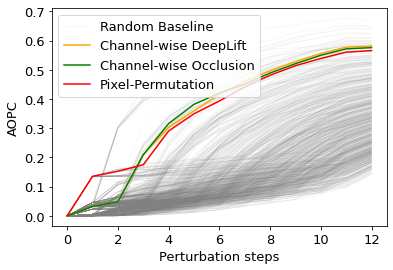

In [167]:
plt.rcParams.update({'font.size': 13})
got_label=False
for ranking in random_rankings:
    if not got_label:
        plt.plot(x, ranking, label  = "Random Baseline", color="grey", linewidth=0.5, alpha=0.1)
        got_label=True
    else:
        plt.plot(x, ranking, color="grey", linewidth=0.5, alpha=0.1)
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
#plt.plot(x, res_random_perturb_reverse, label  = "Random Baseline", color="blue")
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-1010-{}.png".format(dataset_name, str("resnet_all"))))

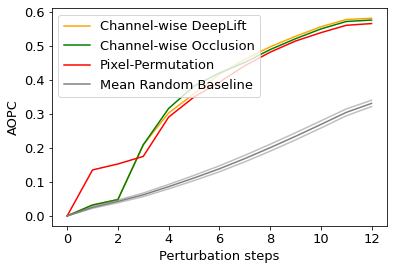

In [169]:
plt.rcParams.update({'font.size': 13})
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
plt.plot(x, mean, label  = "Mean Random Baseline", color="grey")
plt.plot(x, upper_border, color="grey", alpha=0.5)
plt.plot(x, lower_border, color="grey", alpha=0.5)
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-mean-99-random-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-mean-99-random-{}.png".format(dataset_name, str("resnet_all"))))

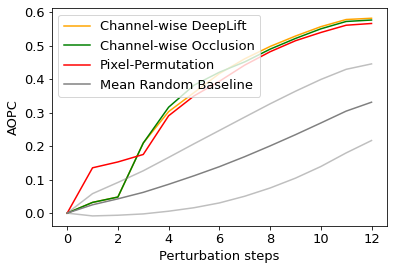

In [170]:
plt.rcParams.update({'font.size': 13})
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
plt.plot(x, mean, label  = "Mean Random Baseline", color="grey")
plt.plot(x, mean+std, color="grey", alpha=0.5)
plt.plot(x, mean-std, color="grey", alpha=0.5)
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-mean-random-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-mean-random-{}.png".format(dataset_name, str("resnet_all"))))

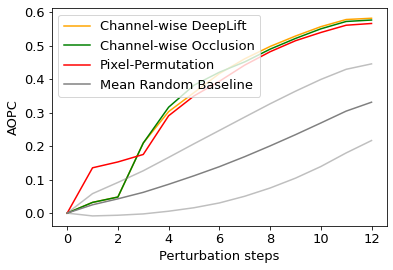

In [173]:
plt.rcParams.update({'font.size': 13})
plt.plot(x, res_deep_lift_perturb_reverse, label  = "Channel-wise DeepLift", color="orange")
plt.plot(x, res_pixel_ocll_perturb_reverse, label  = "Channel-wise Occlusion", color="green")
plt.plot(x, res_pixel_permutated_perturb_reverse, label  = "Pixel-Permutation", color="red")
plt.plot(x, mean, label  = "Mean Random Baseline", color="grey")
plt.plot(x, mean+sample_std, color="grey", alpha=0.5)
plt.plot(x, mean-sample_std, color="grey", alpha=0.5)
plt.xlabel('Perturbation steps')
plt.ylabel('AOPC')
plt.legend()
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-sample-std-random-{}.svg".format(dataset_name, str("resnet_all"))))
plt.savefig(os.path.join("results", "resnet_all", "{}-aopc-all-methods-sample-std-random-{}.png".format(dataset_name, str("resnet_all"))))